# Analisis dan Klasifikasi Time Series Kontur Ikan Menggunakan Dataset Fish

## Tujuan Notebook

Notebook ini bertujuan untuk:

1. **Memahami karakteristik pola kontur ikan** - Menganalisis bagaimana bentuk kontur ikan direpresentasikan sebagai time series dan mengidentifikasi fitur-fitur khas dari setiap pola.

2. **Menganalisis perbedaan pola antar spesies** - Membandingkan karakteristik kontur antar kelas untuk memahami tingkat kemiripan dan perbedaan yang dapat digunakan untuk klasifikasi.

3. **Membandingkan performa beberapa metode klasifikasi time series** - Mengevaluasi berbagai pendekatan klasifikasi (distance-based, feature-based) untuk menemukan metode terbaik dalam membedakan spesies ikan berdasarkan kontur.

Dataset ini merepresentasikan kontur ikan sebagai **univariate time series dengan panjang tetap (463 timesteps)**, menjadikannya cocok untuk analisis time series classification.

## 1. Import Library

**Catatan Metodologis:**

Dataset Fish berisi time series univariate dengan panjang tetap (463 timesteps), sehingga cocok untuk library time series classification. Kita akan menggunakan:

- **numpy, pandas**: Manipulasi data
- **matplotlib, seaborn**: Visualisasi
- **scikit-learn**: Model klasifikasi dan evaluasi
- **scipy**: Pengolahan sinyal dan statistik
- **tslearn/aeon**: Library khusus untuk DTW (Dynamic Time Warping)

In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score, 
    confusion_matrix, 
    classification_report,
    ConfusionMatrixDisplay
)
from tslearn.metrics import cdist_dtw
from tslearn.neighbors import KNeighborsTimeSeriesClassifier
from scipy import stats

## 2. Load Dataset

**Struktur Data:**

Dataset Fish disimpan dalam format `.ts` (Time Series format). Setiap baris merepresentasikan:
- **Time series values**: 463 nilai yang merepresentasikan kontur ikan dalam urutan tertentu
- **Label**: Kelas spesies ikan (1-7)

**Insight Awal:**

Dataset sudah terpisah menjadi train dan test set, sehingga tidak perlu melakukan split ulang. Ini penting untuk menghindari data leakage dan memastikan evaluasi yang fair.

In [36]:
def load_ts_file(filepath):
    data = []
    labels = []
    
    with open(filepath, 'r') as f:
        lines = f.readlines()
        data_started = False
        
        for line in lines:
            line = line.strip()
            
            # Skip comments and metadata
            if line.startswith('#') or line.startswith('@'):
                if line.startswith('@data'):
                    data_started = True
                continue
            
            # Parse data lines
            if data_started and line:
                parts = line.split(':')
                if len(parts) == 2:
                    # Parse time series values
                    ts_values = [float(x) for x in parts[0].split(',')]
                    # Parse label
                    label = int(parts[1])
                    
                    data.append(ts_values)
                    labels.append(label)
    
    return np.array(data), np.array(labels)

# Load datasets
print("Loading Fish dataset...")

X_train, y_train = load_ts_file('dataset/Fish/Fish_TRAIN.ts')
X_test, y_test = load_ts_file('dataset/Fish/Fish_TEST.ts')

Loading Fish dataset...


## 3. Data Quality Check

### 3.1 Pemeriksaan Missing Values

Sebelum melanjutkan analisis, kita perlu memastikan bahwa data tidak mengandung missing values (nilai kosong/NaN). Missing values dapat menyebabkan error dalam proses training model dan mengurangi kualitas hasil prediksi.

In [37]:
# Pemeriksaan Missing Values
print("="*60)
print("PEMERIKSAAN MISSING VALUES")
print("="*60)

# Check missing values di X_train
missing_train = np.isnan(X_train).sum()
missing_train_pct = (missing_train / X_train.size) * 100

# Check missing values di X_test
missing_test = np.isnan(X_test).sum()
missing_test_pct = (missing_test / X_test.size) * 100

# Check missing values di y_train dan y_test
missing_y_train = np.isnan(y_train).sum()
missing_y_test = np.isnan(y_test).sum()

print(f"\nTraining Data (X_train):")
print(f"   - Total values: {X_train.size:,}")
print(f"   - Missing values: {missing_train}")
print(f"   - Missing percentage: {missing_train_pct:.4f}%")

print(f"\nTest Data (X_test):")
print(f"   - Total values: {X_test.size:,}")
print(f"   - Missing values: {missing_test}")
print(f"   - Missing percentage: {missing_test_pct:.4f}%")

print(f"\nLabels (y_train):")
print(f"   - Total values: {len(y_train)}")
print(f"   - Missing values: {missing_y_train}")

print(f"\nLabels (y_test):")
print(f"   - Total values: {len(y_test)}")
print(f"   - Missing values: {missing_y_test}")

# Kesimpulan
print("\n" + "="*60)
if missing_train == 0 and missing_test == 0 and missing_y_train == 0 and missing_y_test == 0:
    print("HASIL: Dataset BERSIH - Tidak ada missing values!")
else:
    print("HASIL: Dataset mengandung missing values yang perlu ditangani!")
print("="*60)

PEMERIKSAAN MISSING VALUES

Training Data (X_train):
   - Total values: 81,025
   - Missing values: 0
   - Missing percentage: 0.0000%

Test Data (X_test):
   - Total values: 81,025
   - Missing values: 0
   - Missing percentage: 0.0000%

Labels (y_train):
   - Total values: 175
   - Missing values: 0

Labels (y_test):
   - Total values: 175
   - Missing values: 0

HASIL: Dataset BERSIH - Tidak ada missing values!


### 3.2 Pengecekan Outlier

Outlier adalah data point yang memiliki nilai ekstrem yang sangat berbeda dari mayoritas data. Dalam konteks time series, kita akan memeriksa outlier menggunakan beberapa metode:

1. **IQR (Interquartile Range)** - Metode statistik untuk deteksi outlier
2. **Z-Score** - Mengukur seberapa jauh nilai dari mean dalam satuan standard deviation
3. **Visualisasi Boxplot** - Untuk melihat distribusi dan outlier secara visual

Untuk data time series, kita akan memeriksa outlier berdasarkan:
- Nilai statistik agregat (mean, std, range) per time series
- Nilai ekstrem pada timestep tertentu

In [38]:
# Deteksi Outlier menggunakan IQR Method
print("="*60)
print("DETEKSI OUTLIER - IQR METHOD")
print("="*60)

# Hitung statistik untuk setiap time series
train_means = np.mean(X_train, axis=1)
train_stds = np.std(X_train, axis=1)
train_mins = np.min(X_train, axis=1)
train_maxs = np.max(X_train, axis=1)
train_ranges = train_maxs - train_mins

def detect_outliers_iqr(data, name):
    """Deteksi outlier menggunakan IQR method"""
    Q1 = np.percentile(data, 25)
    Q3 = np.percentile(data, 75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = (data < lower_bound) | (data > upper_bound)
    n_outliers = np.sum(outliers)
    pct_outliers = (n_outliers / len(data)) * 100
    
    print(f"\n{name}:")
    print(f"   - Q1: {Q1:.4f}")
    print(f"   - Q3: {Q3:.4f}")
    print(f"   - IQR: {IQR:.4f}")
    print(f"   - Lower Bound: {lower_bound:.4f}")
    print(f"   - Upper Bound: {upper_bound:.4f}")
    print(f"   - Outliers detected: {n_outliers} ({pct_outliers:.2f}%)")
    
    return outliers, n_outliers

# Deteksi outlier untuk berbagai statistik
outliers_mean, n_out_mean = detect_outliers_iqr(train_means, "Mean per Time Series")
outliers_std, n_out_std = detect_outliers_iqr(train_stds, "Std Dev per Time Series")
outliers_range, n_out_range = detect_outliers_iqr(train_ranges, "Range per Time Series")

# Total unique outlier samples
outlier_samples = np.where(outliers_mean | outliers_std | outliers_range)[0]
print(f"\n{'='*60}")
print(f"Total unique outlier samples: {len(outlier_samples)} dari {len(X_train)} ({len(outlier_samples)/len(X_train)*100:.2f}%)")
print(f"{'='*60}")

DETEKSI OUTLIER - IQR METHOD

Mean per Time Series:
   - Q1: -0.0000
   - Q3: 0.0000
   - IQR: 0.0000
   - Lower Bound: -0.0000
   - Upper Bound: 0.0000
   - Outliers detected: 0 (0.00%)

Std Dev per Time Series:
   - Q1: 0.9989
   - Q3: 0.9989
   - IQR: 0.0000
   - Lower Bound: 0.9989
   - Upper Bound: 0.9989
   - Outliers detected: 0 (0.00%)

Range per Time Series:
   - Q1: 3.4081
   - Q3: 3.5588
   - IQR: 0.1507
   - Lower Bound: 3.1820
   - Upper Bound: 3.7849
   - Outliers detected: 4 (2.29%)

Total unique outlier samples: 4 dari 175 (2.29%)


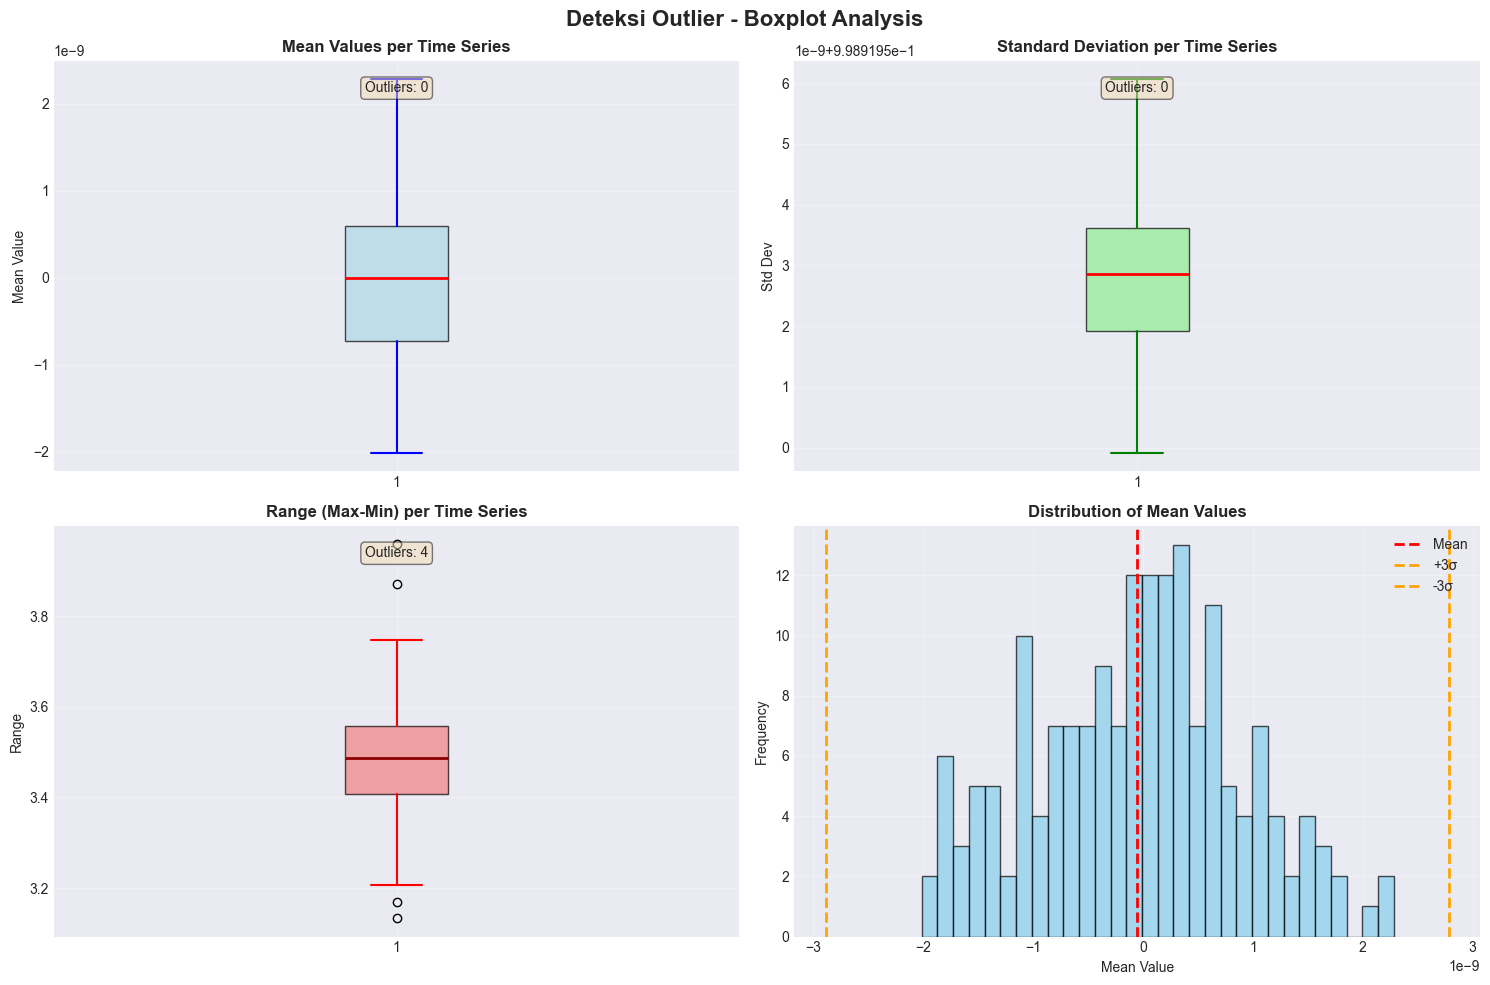

In [39]:
# Visualisasi Outlier dengan Boxplot
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Deteksi Outlier - Boxplot Analysis', fontsize=16, fontweight='bold')

# Boxplot untuk Mean per Time Series
axes[0, 0].boxplot(train_means, vert=True, patch_artist=True,
                    boxprops=dict(facecolor='lightblue', alpha=0.7),
                    medianprops=dict(color='red', linewidth=2),
                    whiskerprops=dict(color='blue', linewidth=1.5),
                    capprops=dict(color='blue', linewidth=1.5))
axes[0, 0].set_title('Mean Values per Time Series', fontweight='bold')
axes[0, 0].set_ylabel('Mean Value')
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].text(0.5, 0.95, f'Outliers: {n_out_mean}', transform=axes[0, 0].transAxes,
                ha='center', va='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# Boxplot untuk Std Dev per Time Series
axes[0, 1].boxplot(train_stds, vert=True, patch_artist=True,
                    boxprops=dict(facecolor='lightgreen', alpha=0.7),
                    medianprops=dict(color='red', linewidth=2),
                    whiskerprops=dict(color='green', linewidth=1.5),
                    capprops=dict(color='green', linewidth=1.5))
axes[0, 1].set_title('Standard Deviation per Time Series', fontweight='bold')
axes[0, 1].set_ylabel('Std Dev')
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].text(0.5, 0.95, f'Outliers: {n_out_std}', transform=axes[0, 1].transAxes,
                ha='center', va='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# Boxplot untuk Range per Time Series
axes[1, 0].boxplot(train_ranges, vert=True, patch_artist=True,
                    boxprops=dict(facecolor='lightcoral', alpha=0.7),
                    medianprops=dict(color='darkred', linewidth=2),
                    whiskerprops=dict(color='red', linewidth=1.5),
                    capprops=dict(color='red', linewidth=1.5))
axes[1, 0].set_title('Range (Max-Min) per Time Series', fontweight='bold')
axes[1, 0].set_ylabel('Range')
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].text(0.5, 0.95, f'Outliers: {n_out_range}', transform=axes[1, 0].transAxes,
                ha='center', va='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# Histogram distribusi Mean values
axes[1, 1].hist(train_means, bins=30, color='skyblue', edgecolor='black', alpha=0.7)
axes[1, 1].axvline(train_means.mean(), color='red', linestyle='--', linewidth=2, label='Mean')
axes[1, 1].axvline(train_means.mean() + 3*train_means.std(), color='orange', linestyle='--', linewidth=2, label='+3σ')
axes[1, 1].axvline(train_means.mean() - 3*train_means.std(), color='orange', linestyle='--', linewidth=2, label='-3σ')
axes[1, 1].set_title('Distribution of Mean Values', fontweight='bold')
axes[1, 1].set_xlabel('Mean Value')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


ANALISIS OUTLIER PER KELAS

Class 1:
   - Total samples: 26
   - Outliers: 0 (0.00%)
   - Mean range: [-0.0000, 0.0000]

Class 2:
   - Total samples: 25
   - Outliers: 0 (0.00%)
   - Mean range: [-0.0000, 0.0000]

Class 3:
   - Total samples: 28
   - Outliers: 0 (0.00%)
   - Mean range: [-0.0000, 0.0000]

Class 4:
   - Total samples: 21
   - Outliers: 3 (14.29%)
   - Mean range: [-0.0000, 0.0000]

Class 5:
   - Total samples: 22
   - Outliers: 0 (0.00%)
   - Mean range: [-0.0000, 0.0000]

Class 6:
   - Total samples: 25
   - Outliers: 0 (0.00%)
   - Mean range: [-0.0000, 0.0000]

Class 7:
   - Total samples: 28
   - Outliers: 0 (0.00%)
   - Mean range: [-0.0000, 0.0000]


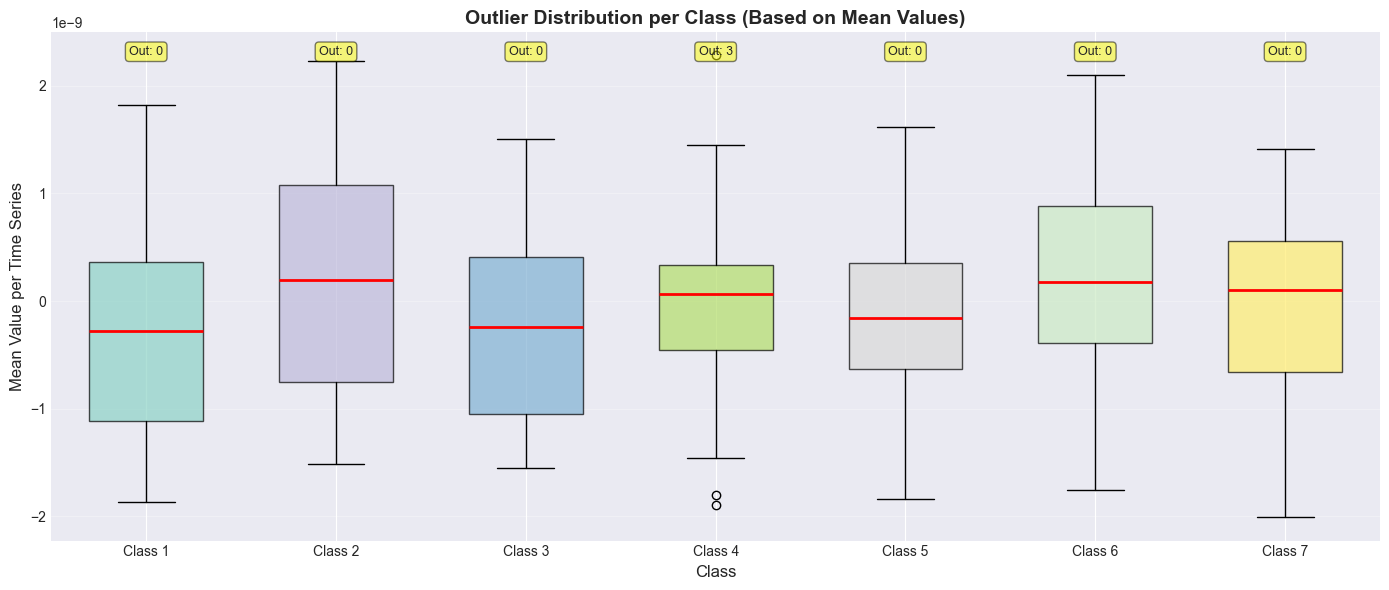

In [40]:
# Deteksi Outlier per Kelas
print("\n" + "="*60)
print("ANALISIS OUTLIER PER KELAS")
print("="*60)

outlier_by_class = {}
for cls in np.unique(y_train):
    class_indices = np.where(y_train == cls)[0]
    class_means = train_means[class_indices]
    
    # IQR untuk class ini
    Q1 = np.percentile(class_means, 25)
    Q3 = np.percentile(class_means, 75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    
    outliers_in_class = np.sum((class_means < lower) | (class_means > upper))
    outlier_by_class[cls] = outliers_in_class
    
    print(f"\nClass {cls}:")
    print(f"   - Total samples: {len(class_indices)}")
    print(f"   - Outliers: {outliers_in_class} ({outliers_in_class/len(class_indices)*100:.2f}%)")
    print(f"   - Mean range: [{class_means.min():.4f}, {class_means.max():.4f}]")

# Visualisasi outlier per kelas
fig, ax = plt.subplots(figsize=(14, 6))

positions = []
data_to_plot = []
labels = []

for i, cls in enumerate(np.unique(y_train)):
    class_indices = np.where(y_train == cls)[0]
    class_means = train_means[class_indices]
    data_to_plot.append(class_means)
    labels.append(f'Class {cls}')
    positions.append(i + 1)

bp = ax.boxplot(data_to_plot, positions=positions, patch_artist=True,
                 labels=labels, widths=0.6)

# Warna berbeda untuk setiap kelas
colors = plt.cm.Set3(np.linspace(0, 1, len(labels)))
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

# Styling
for median in bp['medians']:
    median.set_color('red')
    median.set_linewidth(2)

ax.set_title('Outlier Distribution per Class (Based on Mean Values)', fontsize=14, fontweight='bold')
ax.set_ylabel('Mean Value per Time Series', fontsize=12)
ax.set_xlabel('Class', fontsize=12)
ax.grid(True, alpha=0.3, axis='y')

# Tambahkan informasi jumlah outlier
for i, cls in enumerate(np.unique(y_train)):
    ax.text(i + 1, ax.get_ylim()[1] * 0.95, f'Out: {outlier_by_class[cls]}',
            ha='center', va='top', fontsize=9,
            bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.5))

plt.tight_layout()
plt.show()

## 3. Data Understanding

**Interpretasi Data:**

Setiap baris data merepresentasikan **kontur ikan** yang telah di-encode sebagai sequence of values. Nilai-nilai ini menggambarkan bentuk outline ikan dalam urutan tertentu (misalnya, coordinates atau distance from center dalam polar representation).

Tujuan analisis ini:
- Hitung jumlah kelas dan distribusi data per kelas
- Identifikasi apakah dataset seimbang (balanced)
- Pahami karakteristik statistik dari setiap kelas

In [41]:
print("=" * 70)
print("DATASET OVERVIEW")
print("=" * 70)

# Basic statistics
n_classes = len(np.unique(y_train))
n_train = len(y_train)
n_test = len(y_test)
ts_length = X_train.shape[1]

print(f"\nDataset Size:")
print(f"   • Training samples: {n_train}")
print(f"   • Test samples: {n_test}")
print(f"   • Total samples: {n_train + n_test}")
print(f"   • Time series length: {ts_length}")
print(f"   • Number of classes: {n_classes}")

# Class distribution
print(f"\nClass Distribution:")
print("-" * 70)

train_counts = pd.Series(y_train).value_counts().sort_index()
test_counts = pd.Series(y_test).value_counts().sort_index()

dist_df = pd.DataFrame({
    'Train': train_counts,
    'Test': test_counts,
    'Total': train_counts + test_counts,
    'Train %': (train_counts / n_train * 100).round(2)
})

print(dist_df)

# Check balance
max_ratio = train_counts.max() / train_counts.min()
print(f"\nBalance ratio (max/min): {max_ratio:.2f}")
if max_ratio < 1.5:
    print("   ✓ Dataset is well-balanced")
elif max_ratio < 3:
    print("   ⚠ Dataset is moderately imbalanced")
else:
    print("   ⚠ Dataset is highly imbalanced")

print("\n" + "=" * 70)

DATASET OVERVIEW

Dataset Size:
   • Training samples: 175
   • Test samples: 175
   • Total samples: 350
   • Time series length: 463
   • Number of classes: 7

Class Distribution:
----------------------------------------------------------------------
   Train  Test  Total  Train %
1     26    24     50    14.86
2     25    25     50    14.29
3     28    22     50    16.00
4     21    29     50    12.00
5     22    28     50    12.57
6     25    25     50    14.29
7     28    22     50    16.00

Balance ratio (max/min): 1.33
   ✓ Dataset is well-balanced



### 3.1 Visualisasi Distribusi Kelas

Visualisasi ini menunjukkan seberapa seimbang distribusi data antar kelas, yang penting untuk memahami potensi bias dalam model.

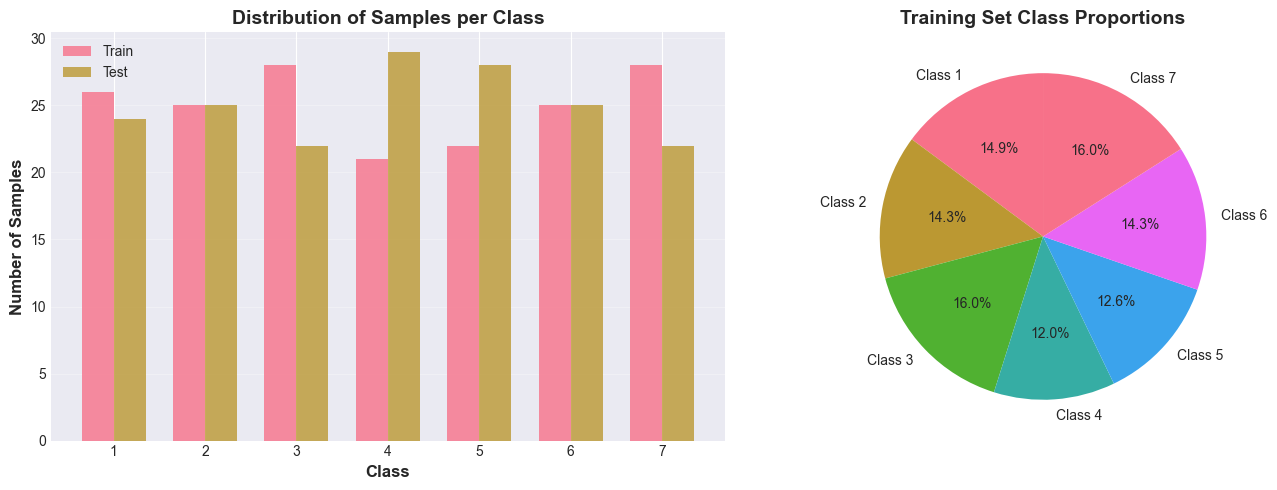

In [42]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Bar chart
train_counts = pd.Series(y_train).value_counts().sort_index()
test_counts = pd.Series(y_test).value_counts().sort_index()

x = np.arange(len(train_counts))
width = 0.35

axes[0].bar(x - width/2, train_counts.values, width, label='Train', alpha=0.8)
axes[0].bar(x + width/2, test_counts.values, width, label='Test', alpha=0.8)
axes[0].set_xlabel('Class', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Number of Samples', fontsize=12, fontweight='bold')
axes[0].set_title('Distribution of Samples per Class', fontsize=14, fontweight='bold')
axes[0].set_xticks(x)
axes[0].set_xticklabels(train_counts.index)
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)

# Plot 2: Pie chart for training set
axes[1].pie(train_counts.values, labels=[f'Class {i}' for i in train_counts.index], 
            autopct='%1.1f%%', startangle=90)
axes[1].set_title('Training Set Class Proportions', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

## 4. Visualisasi Time Series per Kelas (EDA Inti)

**Ini adalah bagian paling penting dari analisis.**

Tujuan:
- Memvisualisasikan pola kontur untuk setiap kelas
- Mengidentifikasi apakah pola antar kelas tampak berbeda secara visual
- Mendeteksi potensi overlap yang dapat menyulitkan klasifikasi
- Memahami variasi intra-class (dalam kelas yang sama)

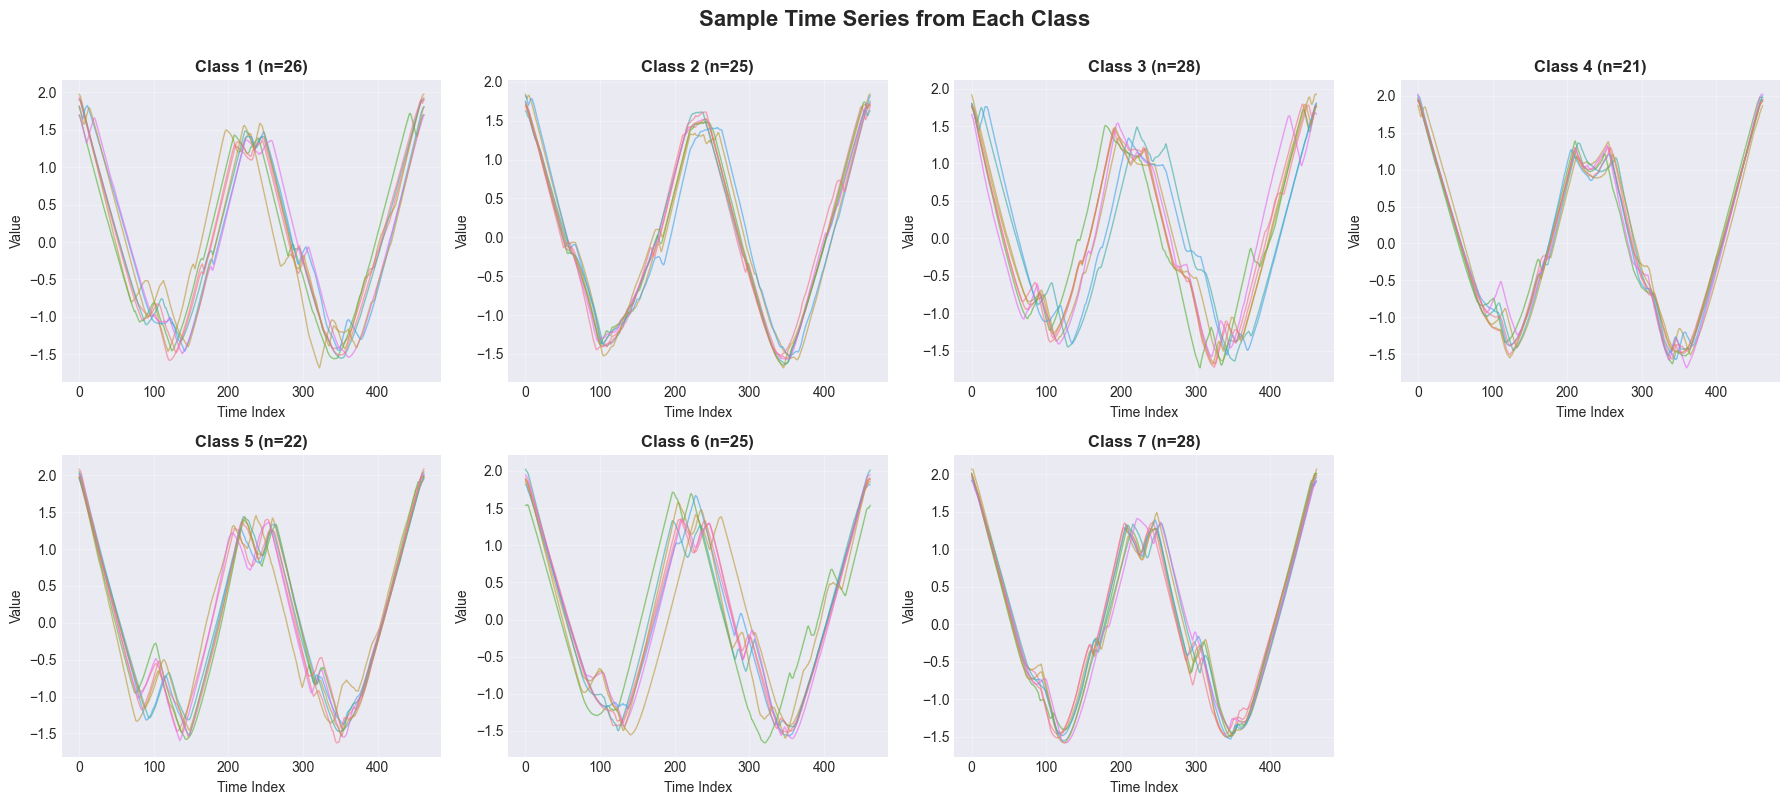

In [43]:
# Plot 5-10 examples per class
n_samples_per_class = 8
classes = sorted(np.unique(y_train))

fig, axes = plt.subplots(2, 4, figsize=(18, 8))
axes = axes.flatten()

for idx, cls in enumerate(classes):
    # Get samples from this class
    class_indices = np.where(y_train == cls)[0]
    sample_indices = np.random.choice(class_indices, 
                                     min(n_samples_per_class, len(class_indices)), 
                                     replace=False)
    
    # Plot each sample
    for i in sample_indices:
        axes[idx].plot(X_train[i], alpha=0.6, linewidth=1)
    
    axes[idx].set_title(f'Class {cls} (n={len(class_indices)})', 
                       fontsize=12, fontweight='bold')
    axes[idx].set_xlabel('Time Index')
    axes[idx].set_ylabel('Value')
    axes[idx].grid(alpha=0.3)

# Remove extra subplot
if len(classes) < 8:
    fig.delaxes(axes[-1])

plt.suptitle('Sample Time Series from Each Class', 
             fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

### 4.1 Overlay Plot: Visualisasi Semua Series per Kelas

Membuat overlay plot untuk melihat variabilitas keseluruhan dalam setiap kelas.

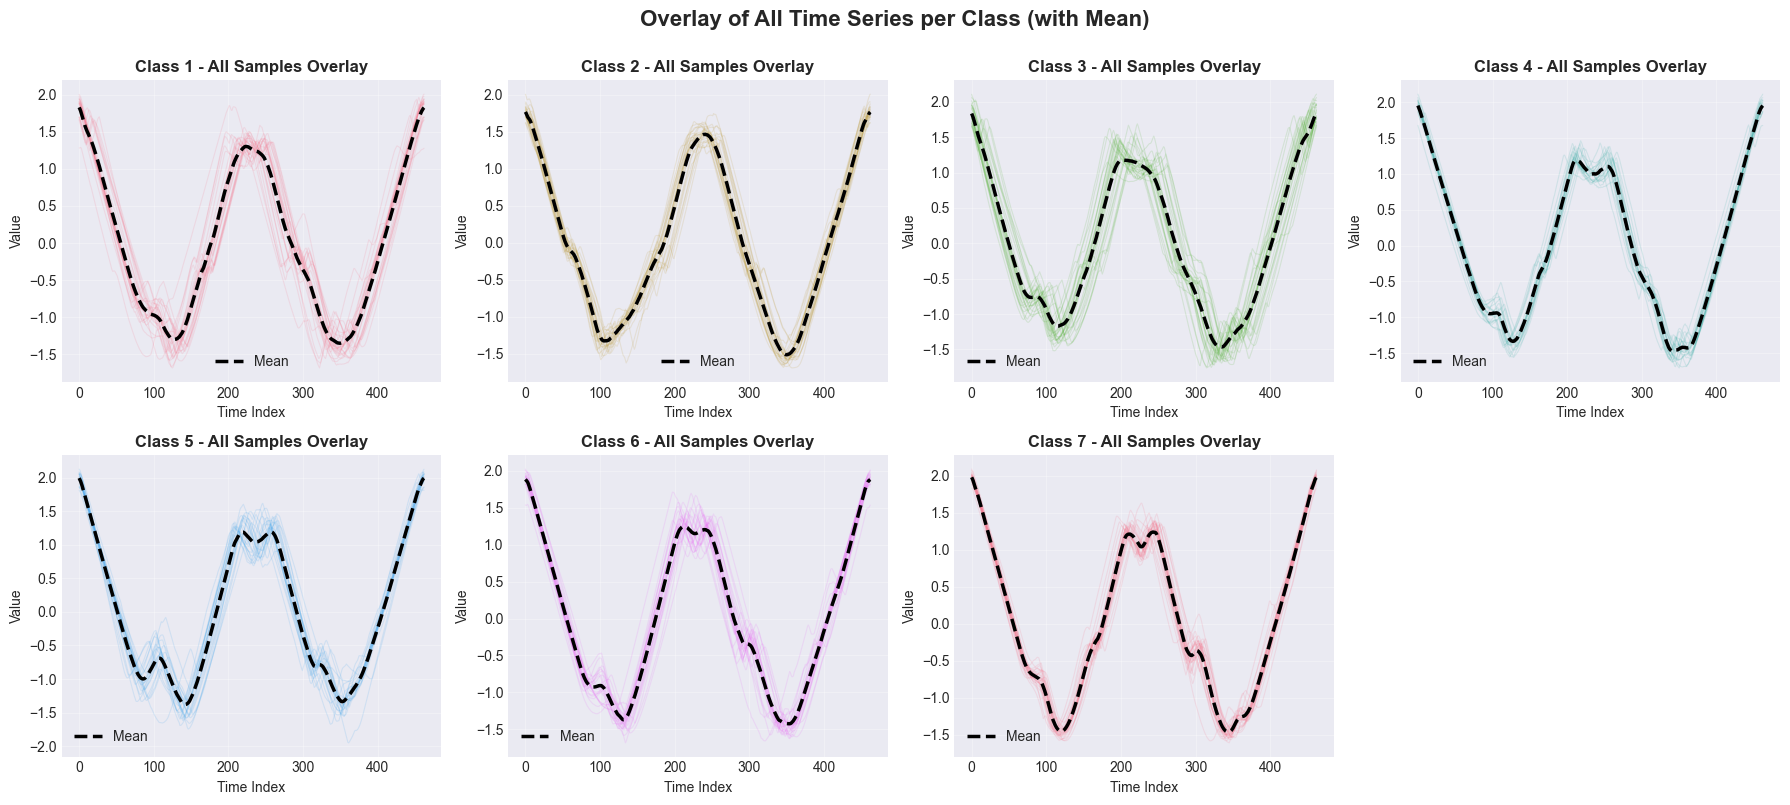

In [44]:
# Create overlay plots for each class
fig, axes = plt.subplots(2, 4, figsize=(18, 8))
axes = axes.flatten()

for idx, cls in enumerate(classes):
    # Get all samples from this class
    class_indices = np.where(y_train == cls)[0]
    
    # Plot all samples with transparency
    for i in class_indices:
        axes[idx].plot(X_train[i], color=f'C{idx}', alpha=0.15, linewidth=0.8)
    
    # Plot mean
    mean_ts = X_train[class_indices].mean(axis=0)
    axes[idx].plot(mean_ts, color='black', linewidth=2.5, label='Mean', linestyle='--')
    
    axes[idx].set_title(f'Class {cls} - All Samples Overlay', 
                       fontsize=12, fontweight='bold')
    axes[idx].set_xlabel('Time Index')
    axes[idx].set_ylabel('Value')
    axes[idx].legend()
    axes[idx].grid(alpha=0.3)

if len(classes) < 8:
    fig.delaxes(axes[-1])

plt.suptitle('Overlay of All Time Series per Class (with Mean)', 
             fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

## 5. Statistik Deskriptif Time Series

**Tujuan:**
- Menghitung mean dan standard deviation time series per kelas
- Mengidentifikasi bagian kontur mana yang paling bervariasi
- Membandingkan variasi internal (intra-class) vs variasi antar kelas (inter-class)

**Insight yang dicari:**
- Apakah variasi dalam kelas lebih kecil dari variasi antar kelas? (penting untuk klasifikasi yang baik)

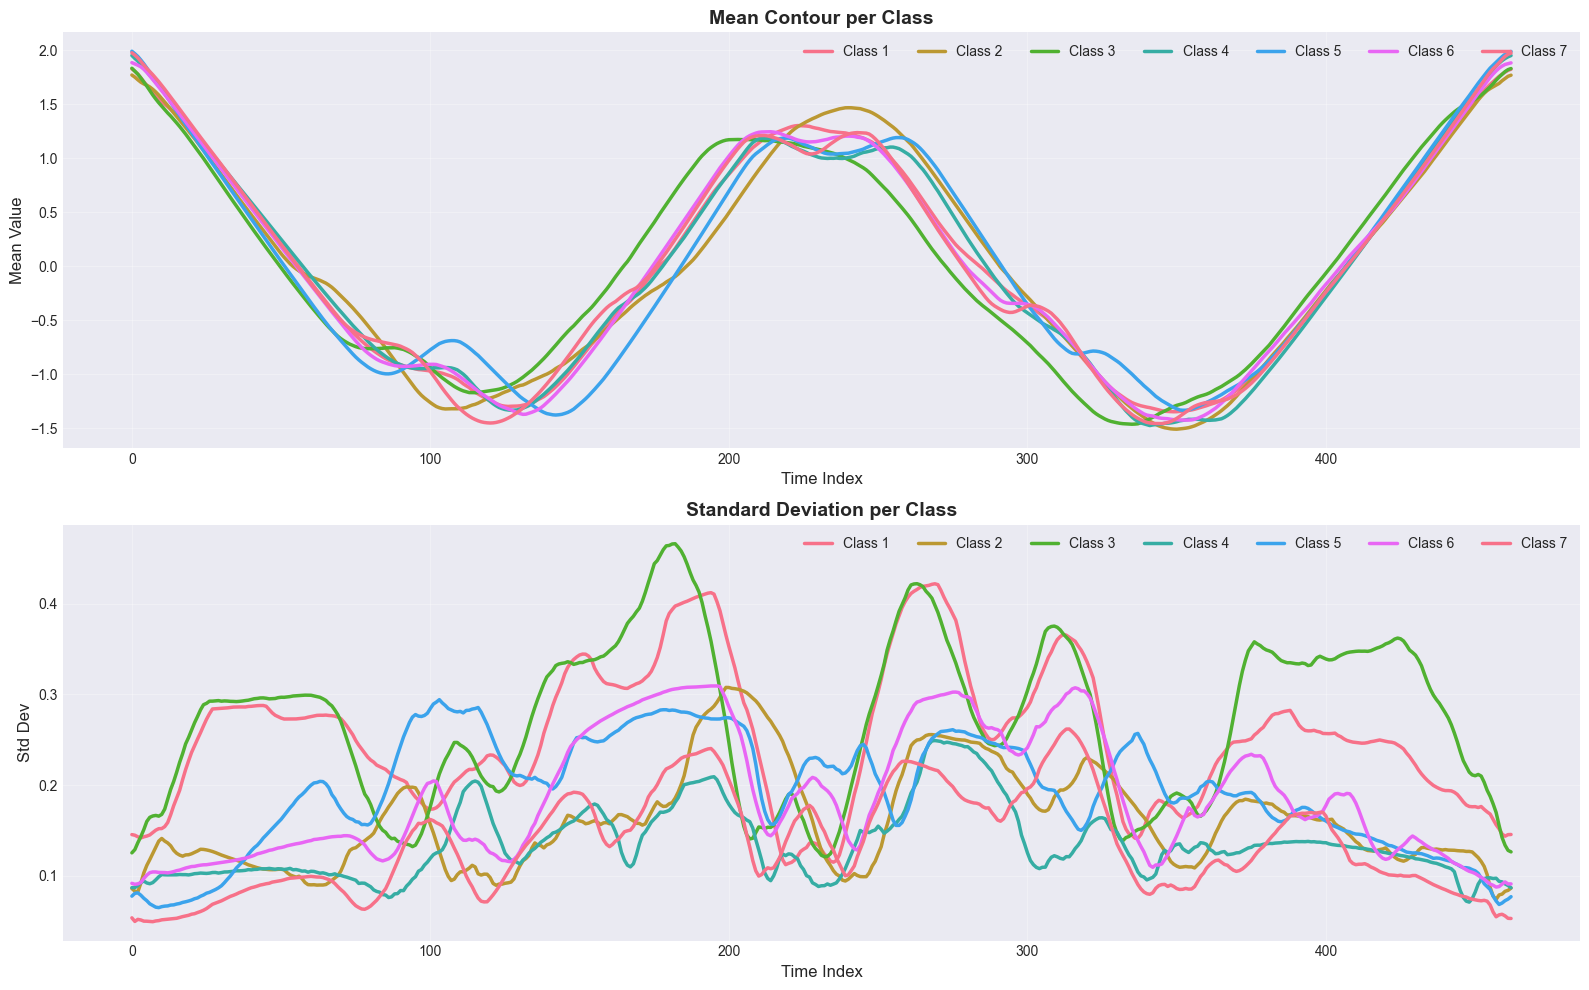


VARIANCE ANALYSIS
Class 1 - Average intra-class std: 0.2547
Class 2 - Average intra-class std: 0.1610
Class 3 - Average intra-class std: 0.2713
Class 4 - Average intra-class std: 0.1350
Class 5 - Average intra-class std: 0.1938
Class 6 - Average intra-class std: 0.1879
Class 7 - Average intra-class std: 0.1350

Average Intra-class variance: 0.1912
Inter-class variance: 0.1302
Ratio (Inter/Intra): 0.68

Inter-class variance ≤ Intra-class variance
  Ini dapat menyulitkan klasifikasi karena overlap antar kelas.


In [46]:
# Calculate mean and std per class
mean_by_class = {}
std_by_class = {}

for cls in classes:
    class_indices = np.where(y_train == cls)[0]
    class_data = X_train[class_indices]
    
    mean_by_class[cls] = class_data.mean(axis=0)
    std_by_class[cls] = class_data.std(axis=0)

# Plot 1: Mean contour for each class
fig, axes = plt.subplots(2, 1, figsize=(16, 10))

for cls in classes:
    axes[0].plot(mean_by_class[cls], label=f'Class {cls}', linewidth=2.5)

axes[0].set_title('Mean Contour per Class', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Time Index', fontsize=12)
axes[0].set_ylabel('Mean Value', fontsize=12)
axes[0].legend(ncol=7, loc='upper right')
axes[0].grid(alpha=0.3)

# Plot 2: Standard deviation per class
for cls in classes:
    axes[1].plot(std_by_class[cls], label=f'Class {cls}', linewidth=2.5)

axes[1].set_title('Standard Deviation per Class', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Time Index', fontsize=12)
axes[1].set_ylabel('Std Dev', fontsize=12)
axes[1].legend(ncol=7, loc='upper right')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Calculate inter-class vs intra-class variance
print("\n" + "=" * 70)
print("VARIANCE ANALYSIS")
print("=" * 70)

# Intra-class variance (average std within each class)
intra_class_var = []
for cls in classes:
    class_indices = np.where(y_train == cls)[0]
    class_data = X_train[class_indices]
    avg_std = class_data.std(axis=0).mean()
    intra_class_var.append(avg_std)
    print(f"Class {cls} - Average intra-class std: {avg_std:.4f}")

# Inter-class variance (std of class means)
all_means = np.array([mean_by_class[cls] for cls in classes])
inter_class_var = all_means.std(axis=0).mean()

print(f"\nAverage Intra-class variance: {np.mean(intra_class_var):.4f}")
print(f"Inter-class variance: {inter_class_var:.4f}")
print(f"Ratio (Inter/Intra): {inter_class_var / np.mean(intra_class_var):.2f}")

if inter_class_var > np.mean(intra_class_var):
    print("\nInter-class variance > Intra-class variance")
    print("  Ini mengindikasikan separabilitas yang baik antar kelas.")
else:
    print("\nInter-class variance ≤ Intra-class variance")
    print("  Ini dapat menyulitkan klasifikasi karena overlap antar kelas.")

## 6. Preprocessing: Z-Score Normalization

**Justifikasi:**

Normalisasi diperlukan karena:
1. **Distance-based classifiers** (k-NN, DTW) sangat sensitif terhadap skala data
2. Z-score normalization membuat setiap time series memiliki mean=0 dan std=1
3. Ini memastikan bahwa perbedaan bentuk (shape), bukan amplitudo, yang menjadi fokus klasifikasi

**Metode:** Normalisasi dilakukan per time series (bukan per timestep) untuk mempertahankan struktur temporal.

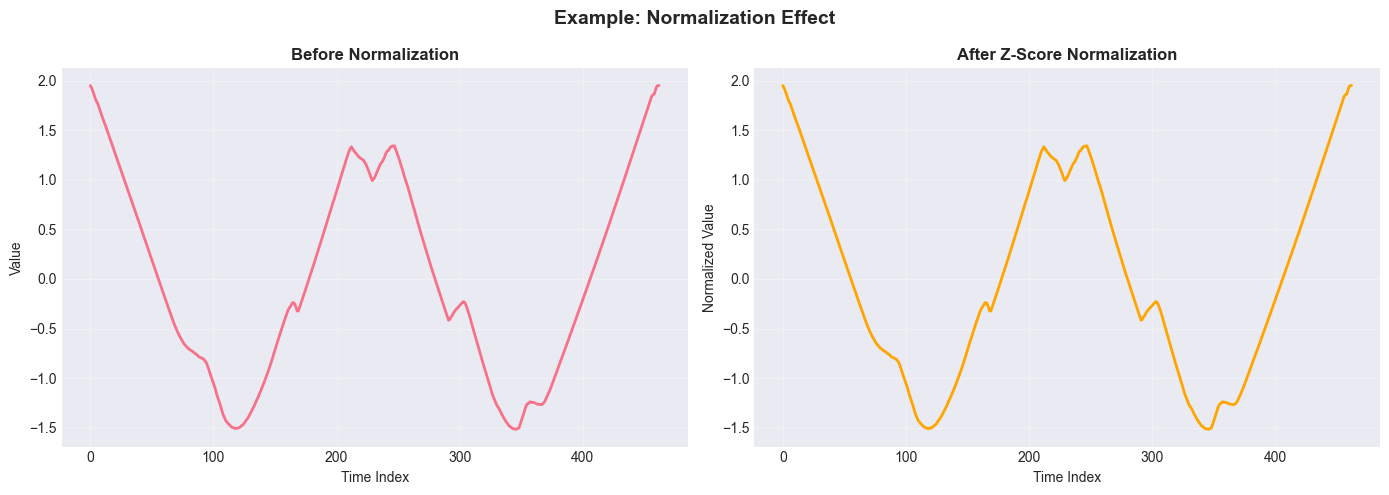

In [48]:
# Z-score normalization per time series
def normalize_ts(X):
    X_normalized = np.zeros_like(X)
    for i in range(X.shape[0]):
        mean = X[i].mean()
        std = X[i].std()
        if std > 0:
            X_normalized[i] = (X[i] - mean) / std
        else:
            X_normalized[i] = X[i] - mean
    return X_normalized

# Normalize both train and test
X_train_norm = normalize_ts(X_train)
X_test_norm = normalize_ts(X_test)

# Visualize before and after normalization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sample_idx = 0
axes[0].plot(X_train[sample_idx], linewidth=2)
axes[0].set_title('Before Normalization', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Time Index')
axes[0].set_ylabel('Value')
axes[0].grid(alpha=0.3)

axes[1].plot(X_train_norm[sample_idx], linewidth=2, color='orange')
axes[1].set_title('After Z-Score Normalization', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Time Index')
axes[1].set_ylabel('Normalized Value')
axes[1].grid(alpha=0.3)

plt.suptitle('Example: Normalization Effect', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## 7. Baseline Model 1: k-NN dengan Euclidean Distance

**Pendekatan:**

Menggunakan k-Nearest Neighbors dengan Euclidean distance sebagai baseline sederhana.

**Rationale:**
- Euclidean distance mengukur jarak point-by-point
- Cocok untuk time series dengan alignment yang baik
- Tidak memperhitungkan time warping/shifting

**Evaluasi:**
- Accuracy
- Confusion matrix untuk identifikasi kelas yang sering salah diklasifikasikan

Training k-NN with Euclidean Distance...
k=1: Test Accuracy = 0.7829
k=3: Test Accuracy = 0.7543
k=5: Test Accuracy = 0.7200
k=7: Test Accuracy = 0.6857
k=9: Test Accuracy = 0.7029

✓ Best k = 1 with accuracy = 0.7829

Final Test Accuracy: 0.7829 (78.29%)


<Figure size 1000x800 with 0 Axes>

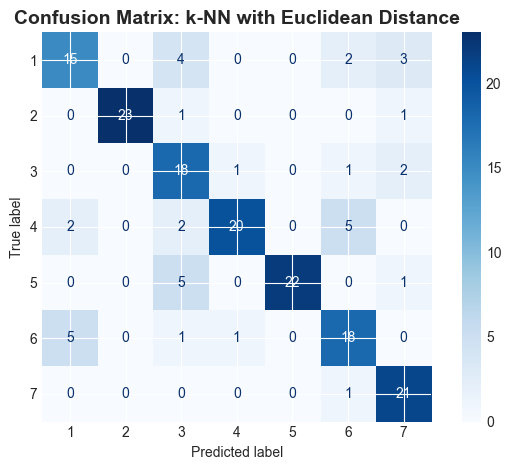


CLASSIFICATION REPORT
              precision    recall  f1-score   support

     Class 1       0.68      0.62      0.65        24
     Class 2       1.00      0.92      0.96        25
     Class 3       0.58      0.82      0.68        22
     Class 4       0.91      0.69      0.78        29
     Class 5       1.00      0.79      0.88        28
     Class 6       0.67      0.72      0.69        25
     Class 7       0.75      0.95      0.84        22

    accuracy                           0.78       175
   macro avg       0.80      0.79      0.78       175
weighted avg       0.81      0.78      0.79       175



In [50]:
# Train k-NN with Euclidean distance
print("Training k-NN with Euclidean Distance...")
print("=" * 70)

# Try different k values
best_k = 1
best_acc = 0

for k in [1, 3, 5, 7, 9]:
    knn = KNeighborsClassifier(n_neighbors=k, metric='euclidean')
    knn.fit(X_train_norm, y_train)
    acc = knn.score(X_test_norm, y_test)
    print(f"k={k}: Test Accuracy = {acc:.4f}")
    
    if acc > best_acc:
        best_acc = acc
        best_k = k

print(f"\n✓ Best k = {best_k} with accuracy = {best_acc:.4f}")

# Train final model
knn_euclidean = KNeighborsClassifier(n_neighbors=best_k, metric='euclidean')
knn_euclidean.fit(X_train_norm, y_train)
y_pred_euclidean = knn_euclidean.predict(X_test_norm)

# Evaluation
accuracy_euclidean = accuracy_score(y_test, y_pred_euclidean)
print(f"\nFinal Test Accuracy: {accuracy_euclidean:.4f} ({accuracy_euclidean*100:.2f}%)")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_euclidean)

plt.figure(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix: k-NN with Euclidean Distance', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Classification report
print("\n" + "=" * 70)
print("CLASSIFICATION REPORT")
print("=" * 70)
print(classification_report(y_test, y_pred_euclidean, target_names=[f'Class {c}' for c in classes]))

## 8. Baseline Model 2: k-NN dengan Dynamic Time Warping (DTW)

**Pendekatan:**

Dynamic Time Warping (DTW) adalah distance metric yang lebih sophisticated untuk time series.

**Keunggulan DTW:**
- Dapat menangani time shifting dan warping
- Lebih robust terhadap small time distortions
- Cocok untuk data kontur yang mungkin memiliki slight variations in alignment

**Ekspektasi:**
DTW seharusnya memberikan hasil lebih baik daripada Euclidean untuk data kontur ikan, karena dapat menangani variasi bentuk yang di-stretched atau compressed.


Training k-NN with DTW Distance...

DTW Test Accuracy: 0.8229 (82.29%)
Euclidean Test Accuracy: 0.7829 (78.29%)
Improvement: 0.0400 (4.00%)


<Figure size 1000x800 with 0 Axes>

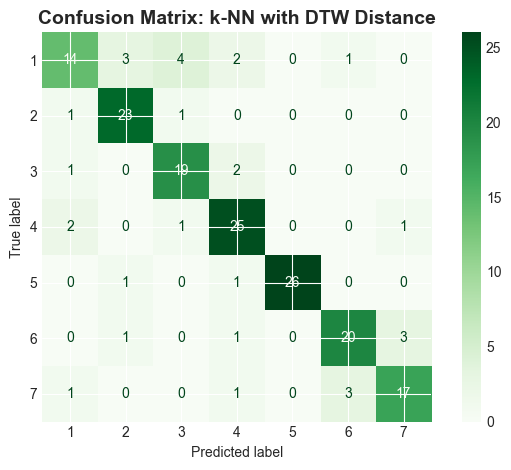


CLASSIFICATION REPORT (DTW)
              precision    recall  f1-score   support

     Class 1       0.74      0.58      0.65        24
     Class 2       0.82      0.92      0.87        25
     Class 3       0.76      0.86      0.81        22
     Class 4       0.78      0.86      0.82        29
     Class 5       1.00      0.93      0.96        28
     Class 6       0.83      0.80      0.82        25
     Class 7       0.81      0.77      0.79        22

    accuracy                           0.82       175
   macro avg       0.82      0.82      0.82       175
weighted avg       0.82      0.82      0.82       175


Analisis Perbandingan:
✓ DTW unggul dari Euclidean distance
  Ini menunjukkan bahwa time warping capability DTW membantu
  menangani variasi alignment dalam bentuk kontur ikan.


In [52]:
# Train k-NN with DTW
print("\nTraining k-NN with DTW Distance...")
print("=" * 70)

# Reshape data for tslearn (n_samples, n_timepoints, 1)
X_train_ts = X_train_norm.reshape((X_train_norm.shape[0], X_train_norm.shape[1], 1))
X_test_ts = X_test_norm.reshape((X_test_norm.shape[0], X_test_norm.shape[1], 1))

# Train with best k from Euclidean
knn_dtw = KNeighborsTimeSeriesClassifier(n_neighbors=best_k, metric='dtw')
knn_dtw.fit(X_train_ts, y_train)

y_pred_dtw = knn_dtw.predict(X_test_ts)
accuracy_dtw = accuracy_score(y_test, y_pred_dtw)

print(f"\nDTW Test Accuracy: {accuracy_dtw:.4f} ({accuracy_dtw*100:.2f}%)")
print(f"Euclidean Test Accuracy: {accuracy_euclidean:.4f} ({accuracy_euclidean*100:.2f}%)")
print(f"Improvement: {(accuracy_dtw - accuracy_euclidean):.4f} ({(accuracy_dtw - accuracy_euclidean)*100:.2f}%)")

# Confusion Matrix
cm_dtw = confusion_matrix(y_test, y_pred_dtw)

plt.figure(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_dtw, display_labels=classes)
disp.plot(cmap='Greens', values_format='d')
plt.title('Confusion Matrix: k-NN with DTW Distance', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Classification report
print("\n" + "=" * 70)
print("CLASSIFICATION REPORT (DTW)")
print("=" * 70)
print(classification_report(y_test, y_pred_dtw, target_names=[f'Class {c}' for c in classes]))

# Analysis
print("\nAnalisis Perbandingan:")
print("=" * 70)
if accuracy_dtw > accuracy_euclidean:
    print("✓ DTW unggul dari Euclidean distance")
    print("  Ini menunjukkan bahwa time warping capability DTW membantu")
    print("  menangani variasi alignment dalam bentuk kontur ikan.")
else:
    print("✓ Euclidean sebanding atau lebih baik dari DTW")
    print("  Ini mengindikasikan bahwa kontur sudah well-aligned dan")
    print("  tidak memerlukan time warping capability.")

## 9. Feature-Based Model (Pembanding)

**Pendekatan:**

Alih-alih menggunakan raw time series, kita ekstrak fitur statistik:
- Mean, Std, Min, Max
- Skewness, Kurtosis
- Energy (sum of squares)
- Range

**Model:** Random Forest Classifier

**Tujuan:**
- Membandingkan representasi statistik vs distance-based approach
- Mengecek apakah agregat statistik cukup menangkap karakteristik bentuk

Extracting statistical features...
✓ Feature shape: (175, 11)
  Features: mean, std, min, max, range, median, q25, q75, skewness, kurtosis, energy

Training Random Forest Classifier...

Random Forest Test Accuracy: 0.6229 (62.29%)


<Figure size 1000x800 with 0 Axes>

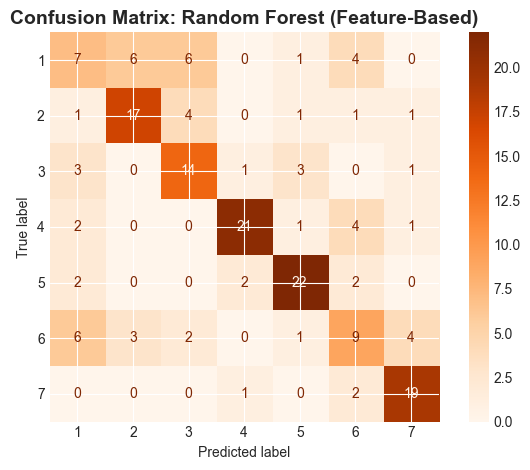

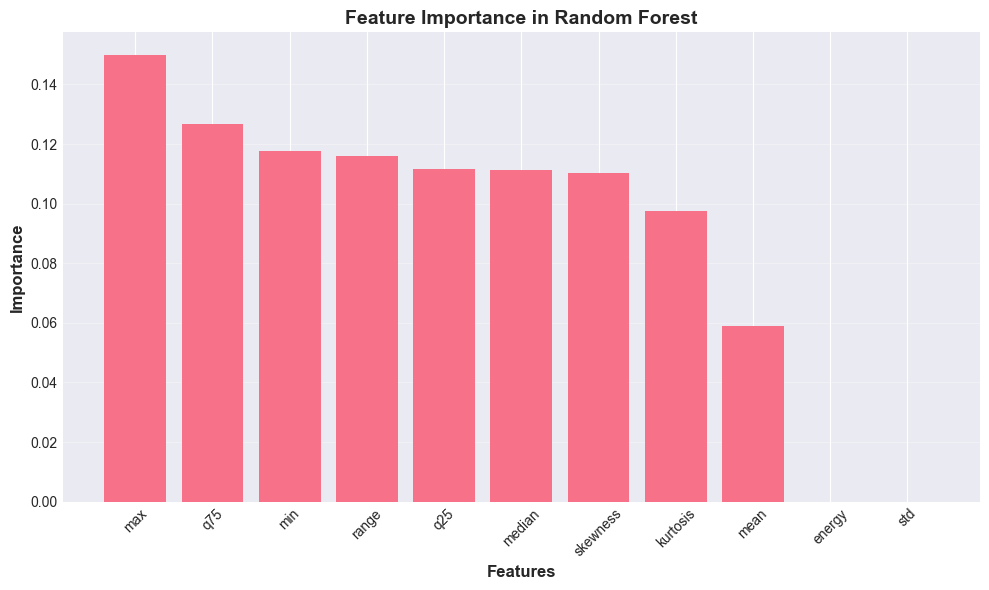

In [58]:
def extract_features(X):
    features = []
    
    for i in range(X.shape[0]):
        ts = X[i]
        
        feat = {
            'mean': np.mean(ts),
            'std': np.std(ts),
            'min': np.min(ts),
            'max': np.max(ts),
            'range': np.max(ts) - np.min(ts),
            'median': np.median(ts),
            'q25': np.percentile(ts, 25),
            'q75': np.percentile(ts, 75),
            'skewness': stats.skew(ts),
            'kurtosis': stats.kurtosis(ts),
            'energy': np.sum(ts**2),
        }
        
        features.append(list(feat.values()))
    
    return np.array(features)

# Extract features
print("Extracting statistical features...")
X_train_feat = extract_features(X_train_norm)
X_test_feat = extract_features(X_test_norm)

print(f"✓ Feature shape: {X_train_feat.shape}")
print(f"  Features: mean, std, min, max, range, median, q25, q75, skewness, kurtosis, energy")

# Train Random Forest
print("\nTraining Random Forest Classifier...")
rf = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=10)
rf.fit(X_train_feat, y_train)

y_pred_rf = rf.predict(X_test_feat)
accuracy_rf = accuracy_score(y_test, y_pred_rf)

print(f"\nRandom Forest Test Accuracy: {accuracy_rf:.4f} ({accuracy_rf*100:.2f}%)")

# Confusion Matrix
cm_rf = confusion_matrix(y_test, y_pred_rf)

plt.figure(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=classes)
disp.plot(cmap='Oranges', values_format='d')
plt.title('Confusion Matrix: Random Forest (Feature-Based)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Feature importance
feature_names = ['mean', 'std', 'min', 'max', 'range', 'median', 'q25', 'q75', 
                'skewness', 'kurtosis', 'energy']
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
plt.bar(range(len(importances)), importances[indices])
plt.xticks(range(len(importances)), [feature_names[i] for i in indices], rotation=45)
plt.xlabel('Features', fontsize=12, fontweight='bold')
plt.ylabel('Importance', fontsize=12, fontweight='bold')
plt.title('Feature Importance in Random Forest', fontsize=14, fontweight='bold')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

## 10. Perbandingan Model

Membuat ringkasan perbandingan seluruh model yang telah diuji.


MODEL COMPARISON
                   Model  Accuracy
              k-NN (DTW)  0.822857
        k-NN (Euclidean)  0.782857
Random Forest (Features)  0.622857


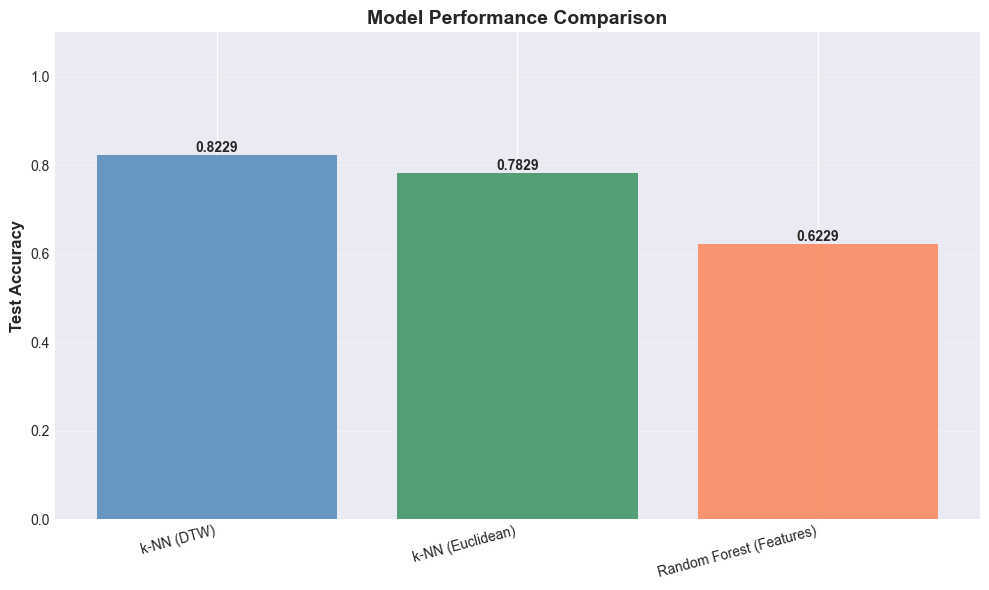

In [59]:
# Model comparison table
comparison_df = pd.DataFrame({
    'Model': [
        'k-NN (Euclidean)',
        'k-NN (DTW)',
        'Random Forest (Features)'
    ],
    'Accuracy': [
        accuracy_euclidean,
        accuracy_dtw,
        accuracy_rf
    ],
})

comparison_df = comparison_df.sort_values('Accuracy', ascending=False)
print("\n" + "=" * 80)
print("MODEL COMPARISON")
print("=" * 80)
print(comparison_df.to_string(index=False))

# Visualize comparison
plt.figure(figsize=(10, 6))
models = comparison_df['Model'].values
accuracies = comparison_df['Accuracy'].values

bars = plt.bar(models, accuracies, color=['steelblue', 'seagreen', 'coral'], alpha=0.8)
plt.ylabel('Test Accuracy', fontsize=12, fontweight='bold')
plt.title('Model Performance Comparison', fontsize=14, fontweight='bold')
plt.ylim(0, 1.1)
plt.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.4f}',
             ha='center', va='bottom', fontweight='bold')

plt.xticks(rotation=15, ha='right')
plt.tight_layout()
plt.show()

## 12. Save Model

Menyimpan model yang telah dilatih agar dapat digunakan kembali tanpa perlu training ulang. Kita akan menyimpan:

1. **Model terbaik** (k-NN DTW, k-NN Euclidean, Random Forest)
2. **Metadata model** (parameter, akurasi, dll)
3. **Preprocessing objects** (untuk normalisasi)

**Format Penyimpanan:**
- `.pkl` (pickle) untuk model scikit-learn dan tslearn
- `.json` untuk metadata model

In [60]:
import pickle
import json
import os
from datetime import datetime

# Buat folder untuk menyimpan model
model_dir = 'model'
os.makedirs(model_dir, exist_ok=True)

print("="*70)
print("SAVING MODELS")
print("="*70)

# 1. Save k-NN Euclidean Model
model_path_euclidean = os.path.join(model_dir, 'knn_euclidean.pkl')
with open(model_path_euclidean, 'wb') as f:
    pickle.dump(knn_euclidean, f)
print(f"\n✓ k-NN Euclidean model saved to: {model_path_euclidean}")

# 2. Save k-NN DTW Model
model_path_dtw = os.path.join(model_dir, 'knn_dtw.pkl')
with open(model_path_dtw, 'wb') as f:
    pickle.dump(knn_dtw, f)
print(f"✓ k-NN DTW model saved to: {model_path_dtw}")

# 3. Save Random Forest Model
model_path_rf = os.path.join(model_dir, 'random_forest.pkl')
with open(model_path_rf, 'wb') as f:
    pickle.dump(rf, f)
print(f"✓ Random Forest model saved to: {model_path_rf}")

# 4. Save normalization function (sebagai dict berisi mean dan std untuk setiap sample)
# Untuk simplicity, kita akan save function-nya sebagai code reference
normalization_info = {
    'method': 'z-score normalization per time series',
    'formula': '(X - mean) / std',
    'note': 'Apply normalization per sample (axis=0) before prediction'
}

# 5. Save Model Metadata
metadata = {
    'timestamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'dataset': 'Fish Time Series Classification',
    'ts_length': int(ts_length),
    'n_classes': int(n_classes),
    'class_labels': [int(c) for c in classes],
    'models': {
        'knn_euclidean': {
            'type': 'KNeighborsClassifier',
            'n_neighbors': int(best_k),
            'metric': 'euclidean',
            'accuracy': float(accuracy_euclidean),
            'file': 'knn_euclidean.pkl'
        },
        'knn_dtw': {
            'type': 'KNeighborsTimeSeriesClassifier',
            'n_neighbors': int(best_k),
            'metric': 'dtw',
            'accuracy': float(accuracy_dtw),
            'file': 'knn_dtw.pkl',
            'note': 'Best performing model'
        },
        'random_forest': {
            'type': 'RandomForestClassifier',
            'n_estimators': 100,
            'max_depth': 10,
            'accuracy': float(accuracy_rf),
            'file': 'random_forest.pkl',
            'features': feature_names
        }
    },
    'preprocessing': normalization_info
}

# Save metadata
metadata_path = os.path.join(model_dir, 'model_metadata.json')
with open(metadata_path, 'w') as f:
    json.dump(metadata, f, indent=2)
print(f"✓ Model metadata saved to: {metadata_path}")

print("\n" + "="*70)
print("ALL MODELS SAVED SUCCESSFULLY!")
print("="*70)
print(f"\nModel files location: ./{model_dir}/")
print(f"  - knn_euclidean.pkl")
print(f"  - knn_dtw.pkl")
print(f"  - random_forest.pkl")
print(f"  - model_metadata.json")

SAVING MODELS

✓ k-NN Euclidean model saved to: model\knn_euclidean.pkl
✓ k-NN DTW model saved to: model\knn_dtw.pkl
✓ Random Forest model saved to: model\random_forest.pkl
✓ Model metadata saved to: model\model_metadata.json

ALL MODELS SAVED SUCCESSFULLY!

Model files location: ./model/
  - knn_euclidean.pkl
  - knn_dtw.pkl
  - random_forest.pkl
  - model_metadata.json


## 13. Load Model dan Testing Manual

Demonstrasi cara melakukan prediksi manual menggunakan model yang telah disimpan. Ini berguna untuk:

1. **Deployment** - Menggunakan model di aplikasi lain tanpa training ulang
2. **Testing individual samples** - Menguji model dengan data baru
3. **Production use** - Implementasi real-world

**Step-by-step:**
1. Load model dari file
2. Load metadata
3. Preprocess data baru (normalisasi)
4. Prediksi menggunakan model
5. Interpretasi hasil

In [61]:
# ===============================
# STEP 1: LOAD MODEL DARI FILE
# ===============================

print("="*70)
print("LOADING SAVED MODELS")
print("="*70)

# Load metadata dulu untuk info
with open('model/model_metadata.json', 'r') as f:
    loaded_metadata = json.load(f)

print("\nModel Information:")
print(f"  - Created: {loaded_metadata['timestamp']}")
print(f"  - Dataset: {loaded_metadata['dataset']}")
print(f"  - Time series length: {loaded_metadata['ts_length']}")
print(f"  - Number of classes: {loaded_metadata['n_classes']}")

# Load k-NN Euclidean
with open('model/knn_euclidean.pkl', 'rb') as f:
    loaded_knn_euclidean = pickle.load(f)
print(f"\n✓ Loaded k-NN Euclidean - Accuracy: {loaded_metadata['models']['knn_euclidean']['accuracy']:.4f}")

# Load k-NN DTW
with open('model/knn_dtw.pkl', 'rb') as f:
    loaded_knn_dtw = pickle.load(f)
print(f"✓ Loaded k-NN DTW - Accuracy: {loaded_metadata['models']['knn_dtw']['accuracy']:.4f}")

# Load Random Forest
with open('model/random_forest.pkl', 'rb') as f:
    loaded_rf = pickle.load(f)
print(f"✓ Loaded Random Forest - Accuracy: {loaded_metadata['models']['random_forest']['accuracy']:.4f}")

print("\n" + "="*70)
print("ALL MODELS LOADED SUCCESSFULLY!")
print("="*70)

LOADING SAVED MODELS

Model Information:
  - Created: 2025-12-15 08:14:50
  - Dataset: Fish Time Series Classification
  - Time series length: 463
  - Number of classes: 7

✓ Loaded k-NN Euclidean - Accuracy: 0.7829
✓ Loaded k-NN DTW - Accuracy: 0.8229
✓ Loaded Random Forest - Accuracy: 0.6229

ALL MODELS LOADED SUCCESSFULLY!



MANUAL TESTING - SINGLE SAMPLE

Testing sample index: 33
   True label: Class 1

Prediction (k-NN Euclidean): Class 1
   ✓ CORRECT!

Prediction (k-NN DTW): Class 1
   ✓ CORRECT!

Prediction (Random Forest): Class 5
   ✗ WRONG!


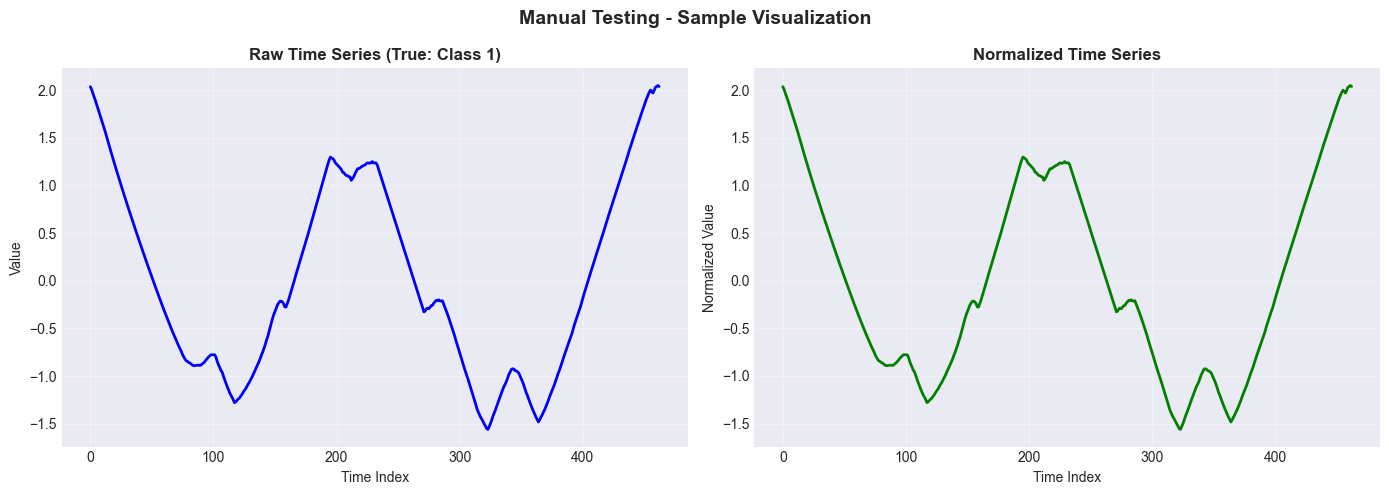

In [63]:
# ===============================
# STEP 2: TESTING MANUAL - Single Sample
# ===============================

print("\n" + "="*70)
print("MANUAL TESTING - SINGLE SAMPLE")
print("="*70)

# Pilih sample random dari test set untuk demo
test_sample_idx = np.random.randint(0, len(X_test))
test_sample_raw = X_test[test_sample_idx]
true_label = y_test[test_sample_idx]

print(f"\nTesting sample index: {test_sample_idx}")
print(f"   True label: Class {true_label}")

# PREPROCESSING: Normalisasi sample (z-score)
def normalize_single_ts(ts):
    """Normalisasi single time series"""
    mean = ts.mean()
    std = ts.std()
    if std > 0:
        return (ts - mean) / std
    else:
        return ts - mean

test_sample_norm = normalize_single_ts(test_sample_raw)

# PREDIKSI DENGAN k-NN EUCLIDEAN
pred_euclidean = loaded_knn_euclidean.predict(test_sample_norm.reshape(1, -1))[0]
print(f"\nPrediction (k-NN Euclidean): Class {pred_euclidean}")
if pred_euclidean == true_label:
    print("   ✓ CORRECT!")
else:
    print("   ✗ WRONG!")

# PREDIKSI DENGAN k-NN DTW
test_sample_dtw = test_sample_norm.reshape(1, -1, 1)  # Reshape untuk DTW
pred_dtw = loaded_knn_dtw.predict(test_sample_dtw)[0]
print(f"\nPrediction (k-NN DTW): Class {pred_dtw}")
if pred_dtw == true_label:
    print("   ✓ CORRECT!")
else:
    print("   ✗ WRONG!")

# PREDIKSI DENGAN RANDOM FOREST (butuh feature extraction)
def extract_single_features(ts):
    """Extract features dari single time series"""
    feat = [
        np.mean(ts),
        np.std(ts),
        np.min(ts),
        np.max(ts),
        np.max(ts) - np.min(ts),
        np.median(ts),
        np.percentile(ts, 25),
        np.percentile(ts, 75),
        stats.skew(ts),
        stats.kurtosis(ts),
        np.sum(ts**2),
    ]
    return np.array(feat).reshape(1, -1)

test_sample_features = extract_single_features(test_sample_norm)
pred_rf = loaded_rf.predict(test_sample_features)[0]
print(f"\nPrediction (Random Forest): Class {pred_rf}")
if pred_rf == true_label:
    print("   ✓ CORRECT!")
else:
    print("   ✗ WRONG!")

# VISUALISASI
plt.figure(figsize=(14, 5))

# Plot raw time series
plt.subplot(1, 2, 1)
plt.plot(test_sample_raw, linewidth=2, color='blue')
plt.title(f'Raw Time Series (True: Class {true_label})', fontsize=12, fontweight='bold')
plt.xlabel('Time Index')
plt.ylabel('Value')
plt.grid(alpha=0.3)

# Plot normalized time series
plt.subplot(1, 2, 2)
plt.plot(test_sample_norm, linewidth=2, color='green')
plt.title(f'Normalized Time Series', fontsize=12, fontweight='bold')
plt.xlabel('Time Index')
plt.ylabel('Normalized Value')
plt.grid(alpha=0.3)

plt.suptitle('Manual Testing - Sample Visualization', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("\n" + "="*70)

In [64]:
# ===============================
# STEP 3: BATCH TESTING - Multiple Samples
# ===============================

print("\n" + "="*70)
print("BATCH TESTING - MULTIPLE SAMPLES")
print("="*70)

# Test dengan 10 random samples
n_test_samples = 10
test_indices = np.random.choice(len(X_test), n_test_samples, replace=False)

results = []

for idx in test_indices:
    sample_raw = X_test[idx]
    sample_norm = normalize_single_ts(sample_raw)
    true_class = y_test[idx]
    
    # Prediksi dengan semua model
    pred_euc = loaded_knn_euclidean.predict(sample_norm.reshape(1, -1))[0]
    pred_dtw = loaded_knn_dtw.predict(sample_norm.reshape(1, -1, 1))[0]
    pred_rf = loaded_rf.predict(extract_single_features(sample_norm))[0]
    
    results.append({
        'Sample_ID': idx,
        'True_Class': true_class,
        'Pred_Euclidean': pred_euc,
        'Pred_DTW': pred_dtw,
        'Pred_RF': pred_rf,
        'Euclidean_Correct': '✓' if pred_euc == true_class else '✗',
        'DTW_Correct': '✓' if pred_dtw == true_class else '✗',
        'RF_Correct': '✓' if pred_rf == true_class else '✗'
    })

# Buat DataFrame untuk visualisasi
results_df = pd.DataFrame(results)

print("\nBatch Testing Results:")
print(results_df.to_string(index=False))

# Hitung akurasi untuk batch ini
acc_euc = np.mean([r['Euclidean_Correct'] == '✓' for r in results])
acc_dtw = np.mean([r['DTW_Correct'] == '✓' for r in results])
acc_rf = np.mean([r['RF_Correct'] == '✓' for r in results])

print("\n" + "="*70)
print("BATCH ACCURACY:")
print(f"  - k-NN Euclidean: {acc_euc:.2%} ({int(acc_euc*n_test_samples)}/{n_test_samples})")
print(f"  - k-NN DTW: {acc_dtw:.2%} ({int(acc_dtw*n_test_samples)}/{n_test_samples})")
print(f"  - Random Forest: {acc_rf:.2%} ({int(acc_rf*n_test_samples)}/{n_test_samples})")
print("="*70)


BATCH TESTING - MULTIPLE SAMPLES

Batch Testing Results:
 Sample_ID  True_Class  Pred_Euclidean  Pred_DTW  Pred_RF Euclidean_Correct DTW_Correct RF_Correct
       163           5               5         5        5                 ✓           ✓          ✓
         4           1               1         1        3                 ✓           ✓          ✗
       152           5               5         5        5                 ✓           ✓          ✓
        22           3               7         3        3                 ✗           ✓          ✓
        30           6               6         6        2                 ✓           ✓          ✗
        26           2               2         2        2                 ✓           ✓          ✓
        12           3               3         3        3                 ✓           ✓          ✓
        56           5               5         5        5                 ✓           ✓          ✓
         1           4               6         1   

## 14. Error Analysis

**Tujuan:**

Melakukan analisis mendalam terhadap kesalahan klasifikasi:
- Identifikasi contoh yang salah diklasifikasikan
- Visualisasikan time series asli vs prediksi
- Bandingkan dengan mean dari kelas sebenarnya dan kelas prediksi

**Insight yang dicari:**

Apakah kesalahan klasifikasi masuk akal secara visual? Apakah kelas-kelas yang dikelirukan memang mirip secara bentuk?

Number of misclassified samples: 31
Misclassification rate: 17.71%


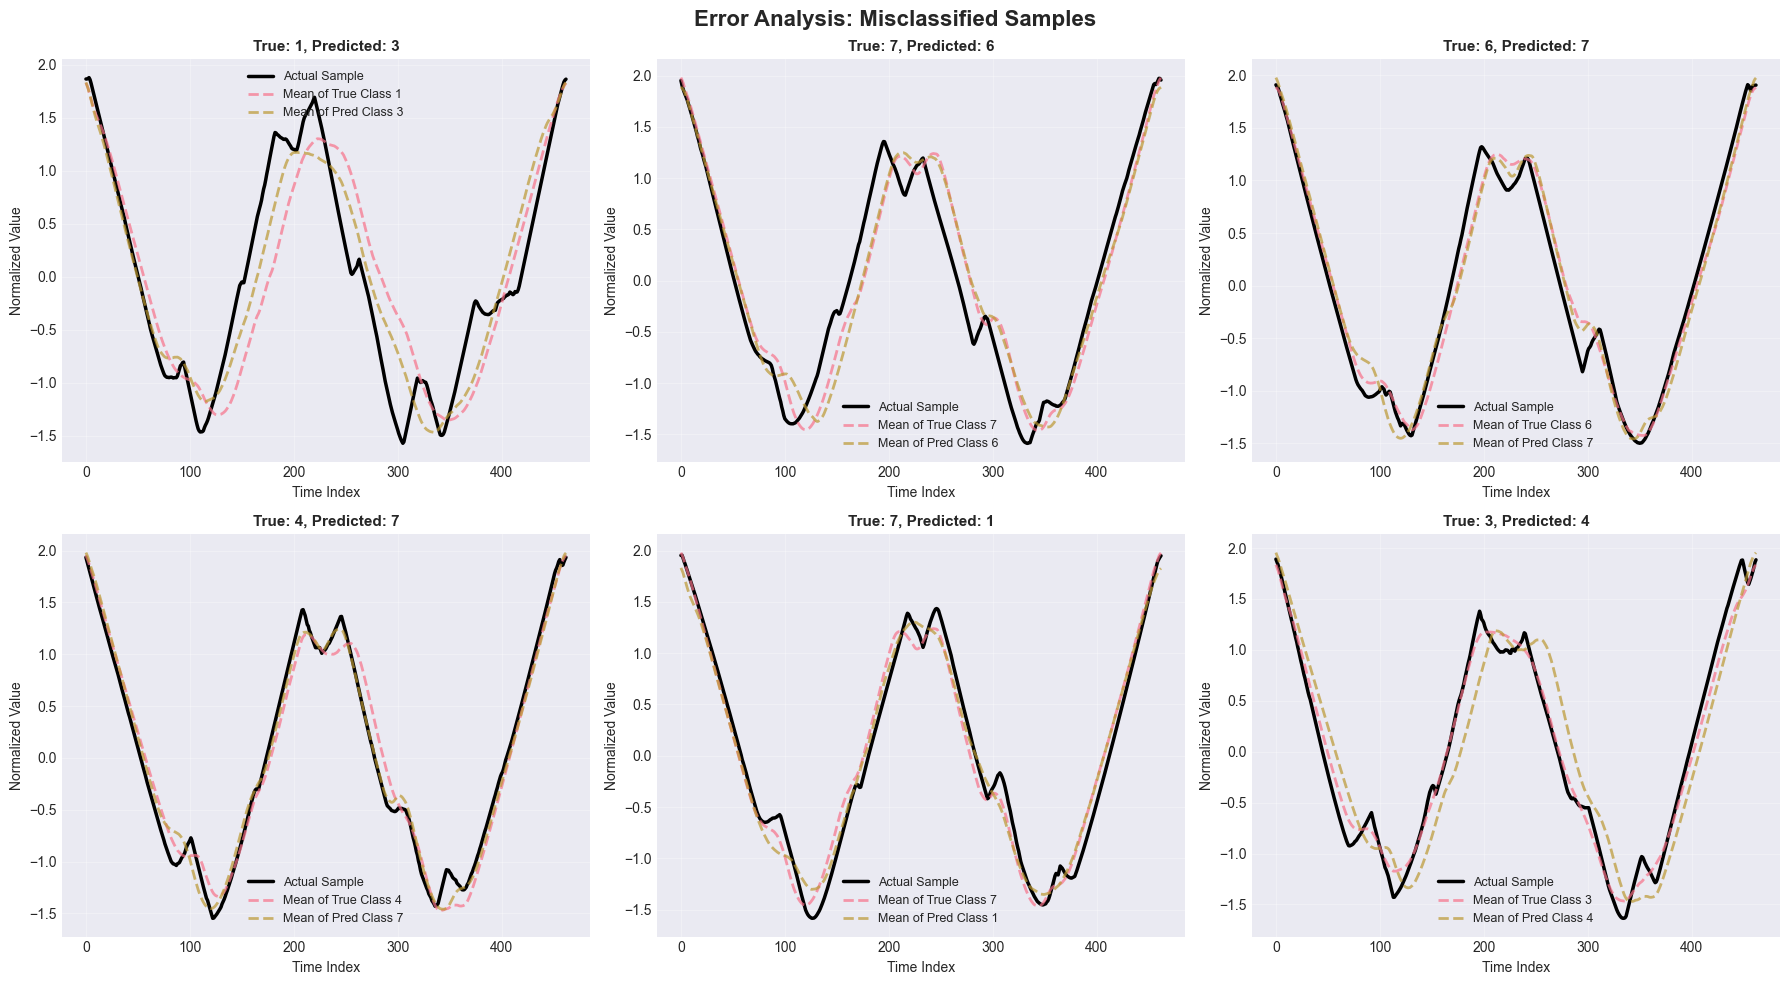

In [65]:
# Find misclassified samples (using best model - DTW)
misclassified_indices = np.where(y_pred_dtw != y_test)[0]

print(f"Number of misclassified samples: {len(misclassified_indices)}")
print(f"Misclassification rate: {len(misclassified_indices)/len(y_test)*100:.2f}%")

# Select some examples for analysis
n_examples = min(6, len(misclassified_indices))
example_indices = np.random.choice(misclassified_indices, n_examples, replace=False)

# Calculate mean time series for each class
mean_by_class = {}
for cls in classes:
    class_indices = np.where(y_train == cls)[0]
    mean_by_class[cls] = X_train_norm[class_indices].mean(axis=0)

# Plot misclassified examples
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for i, idx in enumerate(example_indices):
    if i >= len(axes):
        break
        
    true_label = y_test[idx]
    pred_label = y_pred_dtw[idx]
    
    # Plot the actual time series
    axes[i].plot(X_test_norm[idx], label='Actual Sample', linewidth=2.5, color='black')
    
    # Plot mean of true class
    axes[i].plot(mean_by_class[true_label], label=f'Mean of True Class {true_label}', 
                linewidth=2, linestyle='--', alpha=0.7)
    
    # Plot mean of predicted class
    axes[i].plot(mean_by_class[pred_label], label=f'Mean of Pred Class {pred_label}', 
                linewidth=2, linestyle='--', alpha=0.7)
    
    axes[i].set_title(f'True: {true_label}, Predicted: {pred_label}', 
                     fontsize=11, fontweight='bold')
    axes[i].set_xlabel('Time Index')
    axes[i].set_ylabel('Normalized Value')
    axes[i].legend(fontsize=9)
    axes[i].grid(alpha=0.3)

plt.suptitle('Error Analysis: Misclassified Samples', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()